# Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# Data Content
The <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3"> datasets </a> contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# Exploratory Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.style as style
from IPython.display import HTML
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
style.use('ggplot')
%matplotlib inline

In [2]:
%%time
# df = pd.read_csv("creditcard.csv")
dfs = [pd.read_csv('./data/creditcard_'+str(f)+'.csv') for f in range(1,9)]
df = pd.concat(dfs).reset_index(drop=True)
df=df.drop('Time',axis=1)

Wall time: 9.64 s


In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The target data is Class and amount is the only other feature with sensible data. Value 0 responds to valid transaction and 1 to invalid.

In [4]:
df[['Amount','Class']].describe()

,Amount,Class
count,284807.000000,284807.000000
mean,88.349619,0.001727
std,250.120109,0.041527
min,0.000000,0.000000
25%,5.600000,0.000000
50%,22.000000,0.000000
75%,77.165000,0.000000
max,25691.160000,1.000000


To investigate the target feature and the level of imbalance in Class column, the following should be considered.

In [5]:
(100*df['Class'].value_counts(normalize=True)).to_frame().rename(
    columns={'Class':'Percentage of values'}).join(df['Class'].value_counts(
    normalize=False).to_frame().rename(columns={'Class':'Number of values'}))

,Percentage of values,Number of values
0,99.827251,284315
1,0.172749,492


Clearly the data is imbalanced, as stated earlier. Less than 0.2% of our transactions are invalid. The conventional model evaluation methods do not accurately measure model performance when faced with imbalanced datasets

Standard classifier algorithms have a bias towards classes which have higher number of instances. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class.

In order to tackle this issue, following subjects should be taken into account.

    1. Performance Metric
    2. Resampling Dataset
    3. Synthetic Samples
    4. Cross Validation
    5. Customized Models
    ################# Rejected #################
    *. Imbalanced datasets algorithms; anomaly detection and change detection

In [6]:
################# Rejected #################
# Dropping zero values of amount feature
# data.drop(data[data['Amount']==0].index,inplace=True)

## 1. Performance Metric
Evaluation of a classification algorithm performance is measured by the Confusion Matrix which contains information about the actual and the predicted class.
<img src="img/Confusion_Matrix.png">
Metrics of confusion matrix are defined as following:

\begin{equation*}
Accuracy = \frac{TP+TN}{TP+FP+FN+TN} \\
Precision = \frac{TP}{TP+FP} \\
Recall = \frac{TP}{TP+FN} \\
F1 score = \frac{2 \times Recall \times Precision}{Recall + Precision} 
\end{equation*}


### Receiver Operating Characteristic (ROC)

Unfortunately, there are circumstances where these common metrics derived from confusion matrix do not work well. For example, with a disease that only affects 1 in a million people a completely bogus screening test that always reports “negative” will be 99.9999% accurate. Unlike accuracy, or in general metrics from confusion matrix, ROC curves are insensitive to class imbalance; the bogus screening test would have an AUC of 0.5, which is like not having a test at all.

ROC(Receiver Operating Characteristics) curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. 

The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
<img src="img/AUC%20-%20ROC%20Curve.png">
True Positive Rate (TPR) and False Positive Rate (FPR) are used to plot ROC curve and are defined as follows.
\begin{equation*}
TPR = \frac{TP}{TP+FN} \\
FPR = \frac{FP}{FP+TN} \\
\end{equation*}

In binary classification, assuming that classes are labeled as Positive or Negative, ROC curve calculation process is as following:

    1. Forecast model does prediction test data set, i.e. X not y, results are divided into Positive set and Negative set.
    2. One of the features in test set is selected, It can be any feature, and Probality density function for both Positive set and Negative set is plotted.
    3. Selected feature operates as a threshold, and by moving it from its minimum to maximum, TP, FP, TN, and FN are calculated.
    4. For each threshold, TPR and FPR are calculated and plotted on ROC curve.
<img src="img/ROC%20Curve.png">
In order to summerize the ROC curve, Area Under Curve, i.e. AUC is defined. AUC ranges between 0.5, i.e. lowest performance, and 1, highest performance. AUC increases as the overlap between two PDFs decreases, meaning two classes have less in common leading to a more aaccurate predictor.
<img src="img/ROC%20-%20AUC.png">
As can be seen from the definition of ROC, it does not take into account how the results are compared to the True test values, i.e. y, so it's always helpful to look at one of the less susceptible metrics to data imbalance metric, such as F1-Score.

## 2. Resampling Dataset
Resampling is deivided into two subcatagories, i.e. Oversampling and Undersampling.
<br>Oversampling, by adding more of the minority class so it has more effect on the machine learning algorithm<br>
Undersampling, by removing some of the majority class so it has less effect on the machine learning algorithm
<img src="img/Resampling.jpg">

## 3. Synthetic Samples
Another approach in overcoming the issue of unbalanced data is to synthesize of new ones. 
The best known example of this approach is Chawla’s SMOTE (Synthetic Minority Oversampling TEchnique) system. The idea is to create new minority examples by interpolating between existing ones. The process is basically as follows.
Assume we have a set of majority and minority examples, as before:
<img src="img/SMOTE.png">
It is important to note a substantial limitation of SMOTE. Because it operates by interpolating between rare examples, it can only generate examples within the body of available examples—never outside. Formally, SMOTE can only fill in the convex hull of existing minority examples, but not create new exterior regions of minority examples.

SMOTE uses the K-Nearest-Neighbors algorithm to make "similar" data points to those under sampled ones. Unlike the conventional resampling technique, It is vital that SMOTE not be implemented on the full data set, meaning it should be used only on the training set and then validate on the validation set. 

For train/test split of unbalanced data, in order to make sure test and train sets have the same proportion of classes, stratified cross-validation should be used. Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole. For example in a binary classification problem where each class comprises 50% of the data, it is best to arrange the data such that in every fold, each class comprises around half the instances.

## 4. Cross Validation
When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set , there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using  of the folds as training data;
the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

## 5. Customized Models
Classification algorithms are used when the desired output is a discrete label. In other words, they’re helpful when the answer to your question about your business falls under a finite set of possible outcomes. Based on the data type classification can be supervised or unsupervised. In the current case study data is labeled/supervised, so the following approaches are the most effective algorithms.

### 1.Logistic Regression
   Definition: Logistic regression is a machine learning algorithm for classification. In this algorithm, the probabilities describing the possible outcomes of a        single trial are modelled using a logistic function.

   Advantages: Logistic regression is designed for this purpose (classification), and is most useful for understanding the influence of several independent variables    on a single outcome variable.

   Disadvantages: Works only when the predicted variable is binary, assumes all predictors are independent of each other, and assumes data is free of missing values.

### 2. Decision Tree
   Definition: Given a data of attributes together with its classes, a decision tree produces a sequence of rules that can be used to classify the data.

   Advantages: Decision Tree is simple to understand and visualise, requires little data preparation, and can handle both numerical and categorical data.

   Disadvantages: Decision tree can create complex trees that do not generalise well, and decision trees can be unstable because small variations in the data might      result in a completely different tree being generated.

### 3. Random Forest
   Definition: Random forest classifier is a meta-estimator that fits a number of decision trees on various sub-samples of datasets and uses average to improve the      predictive accuracy of the model and controls over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn        with replacement.

   Advantages: Reduction in over-fitting and random forest classifier is more accurate than decision trees in most cases.

   Disadvantages: Slow real time prediction, difficult to implement, and complex algorithm.

### 4. Support Vector Machine
   Definition: Support vector machine is a representation of the training data as points in space separated into categories by a clear gap that is as wide as            possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

   Advantages: Effective in high dimensional spaces and uses a subset of training points in the decision function so it is also memory efficient.

   Disadvantages: The algorithm does not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

# Resampling

Data first is divided into two classes according to class column values, then each set is splitted to two parts, one is data, which goes for training, and the other is for validation.
Three Resampling methods will be utilized, as discussed above.

In [7]:
################# Resampling Dataset #################

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Train/Test Split Parameters
test_size=0.3
random_state=0

# Splitting df into data and data_validation
df_valid   = df[df['Class']==0]   # majority class
df_invalid = df[df['Class']==1]   # minority class

data1, data_validation1 = train_test_split(df_valid, test_size=test_size, random_state=random_state)
data2, data_validation2 = train_test_split(df_invalid, test_size=test_size, random_state=random_state)

data=pd.concat([data1, data2])
data_validation=pd.concat([data_validation1, data_validation2])
X_validation=data_validation.drop(['Class'],axis=1).values
y_validation=data_validation['Class'].values

# Separate majority and minority classes
data_valid   = data[data['Class']==0]   # majority class
data_invalid = data[data['Class']==1]   # minority class
n_samples_valid=len(data_valid.index)
n_samples_invalid=len(data_invalid.index)


################# Oversampling
# Upsample minority/invalid class
data_invalid_upsampled = resample(data_invalid,
                                  replace=True,                 # sample with replacement
                                  n_samples=n_samples_valid,    # to match majority class
                                  random_state=random_state)    # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([data_valid, data_invalid_upsampled])
print('OverSampling Data Count')
print(df_upsampled['Class'].value_counts())
print('\n')
OS_X_train, OS_X_test, OS_y_train, OS_y_test = train_test_split(df_upsampled.drop(['Class'],axis=1),
                                                                df_upsampled['Class'], test_size=test_size, random_state=random_state)

################# Undersampling
# Downsample majority/valid class
data_valid_downsampled = resample(data_valid, 
                                  replace=False,                 # sample with replacement
                                  n_samples=n_samples_invalid,   # to match minority class
                                  random_state=random_state)     # reproducible results

# Combine majority class with upsampled minority class
df_downsampled = pd.concat([data_valid_downsampled, data_invalid])
print('UnderSampling Data Count')
print(df_downsampled['Class'].value_counts())
US_X_train, US_X_test, US_y_train, US_y_test = train_test_split(df_downsampled.drop(['Class'],axis=1),
                                                                df_downsampled['Class'], test_size=test_size, random_state=random_state)

OverSampling Data Count
1    199020
0    199020
Name: Class, dtype: int64


UnderSampling Data Count
1    344
0    344
Name: Class, dtype: int64


Since SMOTE uses KNN, it should be investigated whether the two classes are separated enough or not. For this purpose, the distribution plot of first 5 Principal Components 
is plotted. For the time being the visual representation of data should suffice. Further performance analysis will be taken into account, when performance of models are represented.

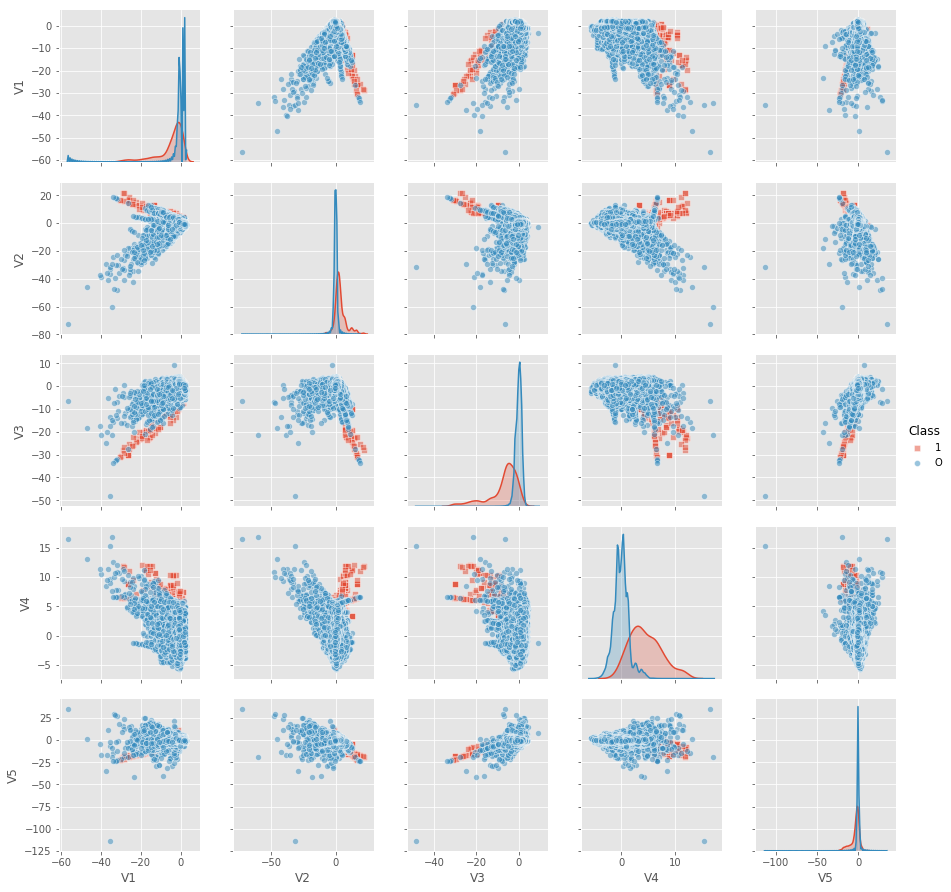

In [8]:
################# Synthetic Sampling/ SMOTE Resampling #################
colors = {1:'red', 0:'blue'}
classmap= {1:'1', 0:'O'}
df1=data[['V1','V2','V3','V4','V5','Class']]
df1.Class=df1.Class.apply(lambda x: classmap[x])

import seaborn as sns
# sns.set(style="ticks", color_codes=True)

g= sns.pairplot(df, hue='Class',hue_order=['1', 'O'],
                markers=['s', 'o'],plot_kws={'alpha': 0.5})

Classes start overlapping from 5th PCA, so a decrease in performance of models which used resampling data from SMOTE is expected.

In [9]:
SMOTE_X_train_0, SMOTE_X_test, SMOTE_y_train_0, SMOTE_y_test = train_test_split(
    data.drop(['Class'],axis=1),
    data['Class'], test_size=test_size, 
    random_state=random_state, stratify=data['Class'])

In [10]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', k_neighbors=3,
           random_state=random_state,n_jobs=8)
SMOTE_X_train, SMOTE_y_train = sm.fit_sample(SMOTE_X_train_0, SMOTE_y_train_0)

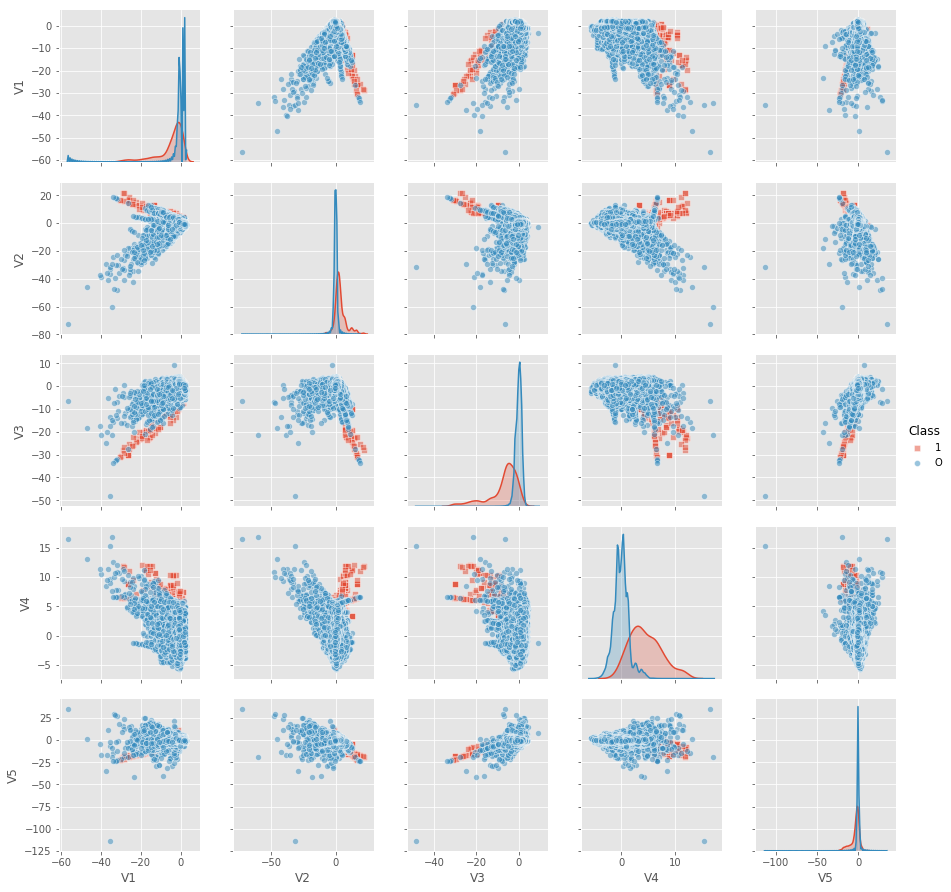

In [11]:
df2=pd.DataFrame(data=SMOTE_X_train, columns=data.drop('Class',axis=1).columns)
df3=pd.DataFrame(data=SMOTE_y_train, columns=['Class'])
df4=pd.concat([df2, df3], axis=1)
df4=data[['V1','V2','V3','V4','V5','Class']]
df4.Class=df4.Class.apply(lambda x: classmap[x])

g= sns.pairplot(df4, hue='Class',hue_order=['1', 'O'],
                markers=['s', 'o'],plot_kws={'alpha': 0.5})

As depicted above, data generated using SMOTE is similar to initial distribution plot, which means synthesized samples are within the acceptable vicinity.
Following table is created to sum-up resampled data.

## Resampling summary

To sum up the result of resampling, the following table is created. It should be noted that the data, obtained in previuos section, is divided into train and test for predictive model to work. <br>
Class 1: Invalid Transaction <br>
Class 0: Valid Transaction

In [12]:
Table={}

N_Train=np.unique(OS_y_train, return_counts=True)[1]
N_Test=np.unique(OS_y_test, return_counts=True)[1]
Table['Oversampling']=pd.DataFrame(columns=['Name', 'Class 0', 'Class 1'],
                                         data=[['Train', N_Train[0], N_Train[1]],
                                               ['Test', N_Test[0], N_Test[1]]]).set_index('Name')

N_Train=np.unique(US_y_train, return_counts=True)[1]
N_Test=np.unique(US_y_test, return_counts=True)[1]
Table['Undersampling']=pd.DataFrame(columns=['Name', 'Class 0', 'Class 1'],
                                         data=[['Train', N_Train[0], N_Train[1]],
                                               ['Test', N_Test[0], N_Test[1]]]).set_index('Name')

N_Train=np.unique(SMOTE_y_train, return_counts=True)[1]
N_Test=np.unique(SMOTE_y_test, return_counts=True)[1]
Table['SMOTE']=pd.DataFrame(columns=['Name', 'Class 0', 'Class 1'],
                                         data=[['Train', N_Train[0], N_Train[1]],
                                               ['Test', N_Test[0], N_Test[1]]]).set_index('Name')
Table=pd.concat(Table, axis=1)
Table=Table[['Oversampling', 'Undersampling', 'SMOTE']]
Table

Oversampling         Undersampling           SMOTE        
           Class 0 Class 1       Class 0 Class 1 Class 0 Class 1
Name                                                            
Train       138939  139689           245     236  139313  139313
Test         60081   59331            99     108   59707     103

# Modeling
In order to find the best tuning paameters for predictive models, GridSearchCV is used. This module takes in a set of parameters for optimization, and run the model on each of them.
Scoring is done on AUC of the model, and the best predictor is selected based on the AUC Rank of models.
GridSearch performs cross-validation with 5 StratifiedKFold splits.

In [13]:
DataSets= {'OverSampling':[OS_X_train, OS_y_train, OS_X_test, OS_y_test],
           'UnderSampling':[US_X_train, US_y_train, US_X_test, US_y_test],
           'SMOTE Sampling':[SMOTE_X_train, SMOTE_y_train, SMOTE_X_test, SMOTE_y_test]
          }
Names= ['OverSampling', 'UnderSampling', 'SMOTE Sampling']

Metrics=['mean_test_f1', 'mean_test_roc_auc', "rank_test_roc_auc"]

MetricsDic={'mean_test_f1':'F1-Score', 
            'mean_test_roc_auc':'AUC',
            "rank_test_roc_auc":'AUC Rank'}

MT={}

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from functions import ModelTable

## 1. Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
# grid={"C":[0.01, 0.02, 0.05, 0.07, 1, 2, 5, 10], "penalty":["l1", "l2"], "random_state":[random_state]}
grid={"C":[1, 2], "penalty":["l1"], "random_state":[random_state]}
clf=LogisticRegression()
clf_name='LogisticRegression'

MT[clf_name]=ModelTable(clf, grid, DataSets, Metrics, MetricsDic, Names)
MT[clf_name]['Table']

Parameters         OverSampling                    UnderSampling                    SMOTE Sampling                   
           C penalty     F1-Score       AUC AUC Rank      F1-Score       AUC AUC Rank       F1-Score       AUC AUC Rank
0          1      l1     0.945820  0.985803        2      0.927115  0.970722        1       0.958575  0.992639        2
1          2      l1     0.945817  0.985809        1      0.929475  0.964307        2       0.958576  0.992642        1

## 2. DecisionTree

In [16]:
from sklearn.tree import DecisionTreeClassifier

# grid={'min_samples_split':[0.1, 0.25, 0.5], 'min_samples_leaf':[0.1, 0.2, 0.3, 0.4],
#     'criterion':['gini', 'entropy'], 
#     "random_state":[random_state]}
grid={'min_samples_split':[0.01, 0.02], 'min_samples_leaf':[0.01],
    'criterion':['gini'], 
    "random_state":[random_state]}
clf=DecisionTreeClassifier()
clf_name='DecisionTree'


MT[clf_name]=ModelTable(clf, grid, DataSets, Metrics, MetricsDic, Names)
MT[clf_name]['Table']

Parameters                            OverSampling                    UnderSampling                   SMOTE Sampling                   
  min_samples_split min_samples_leaf criterion     F1-Score       AUC AUC Rank      F1-Score      AUC AUC Rank       F1-Score       AUC AUC Rank
0              0.01             0.01      gini     0.954508  0.993887        1      0.901873  0.92473        1       0.954176  0.993097        1
1              0.02             0.01      gini     0.954508  0.993887        1      0.901873  0.92473        1       0.954176  0.993097        1

## 3. Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

# grid={'n_estimators':[10, 50, 100], 'min_samples_split':[0.1, 0.25, 0.5], 'min_samples_leaf':[0.1, 0.2, 0.3, 0.4],
#     'criterion':['gini', 'entropy'], 
#     "random_state":[random_state]}
grid={'n_estimators':[10, 20], 'min_samples_split':[0.1], 'min_samples_leaf':[0.1],
    'criterion':['gini'], 
    "random_state":[random_state]}

clf=RandomForestClassifier()
clf_name='RandomForest'

MT[clf_name]=ModelTable(clf, grid, DataSets, Metrics, MetricsDic, Names)
MT[clf_name]['Table']

Parameters                                              OverSampling                    UnderSampling                    SMOTE Sampling                   
  n_estimators min_samples_split min_samples_leaf criterion     F1-Score       AUC AUC Rank      F1-Score       AUC AUC Rank       F1-Score       AUC AUC Rank
0           10               0.1              0.1      gini     0.925678  0.973858        2      0.927229  0.966927        2       0.934055  0.981773        1
1           20               0.1              0.1      gini     0.923766  0.975073        1      0.921044  0.967688        1       0.929537  0.980451        2

## 4. Support Vector Machine

In [18]:
# from sklearn.svm import SVC
# grid={'kernel' : ['linear', 'rbf', 'poly'], 'C': [0.1, 1, 10],
#       "random_state":[random_state]}

# # grid={'kernel' : ['poly'],'gamma':['auto'],
# #     "random_state":[random_state]}

# clf=SVC()
# clf_name='SVC'

# MT[clf_name]=ModelTable(clf, grid, DataSets, Metrics, MetricsDic, Names)
# MT[clf_name]['Table']

## Best Performing Models
Based on AUC and F1 scoring metrics, the following charts are created to illustrate the best performing parameters for each model.   

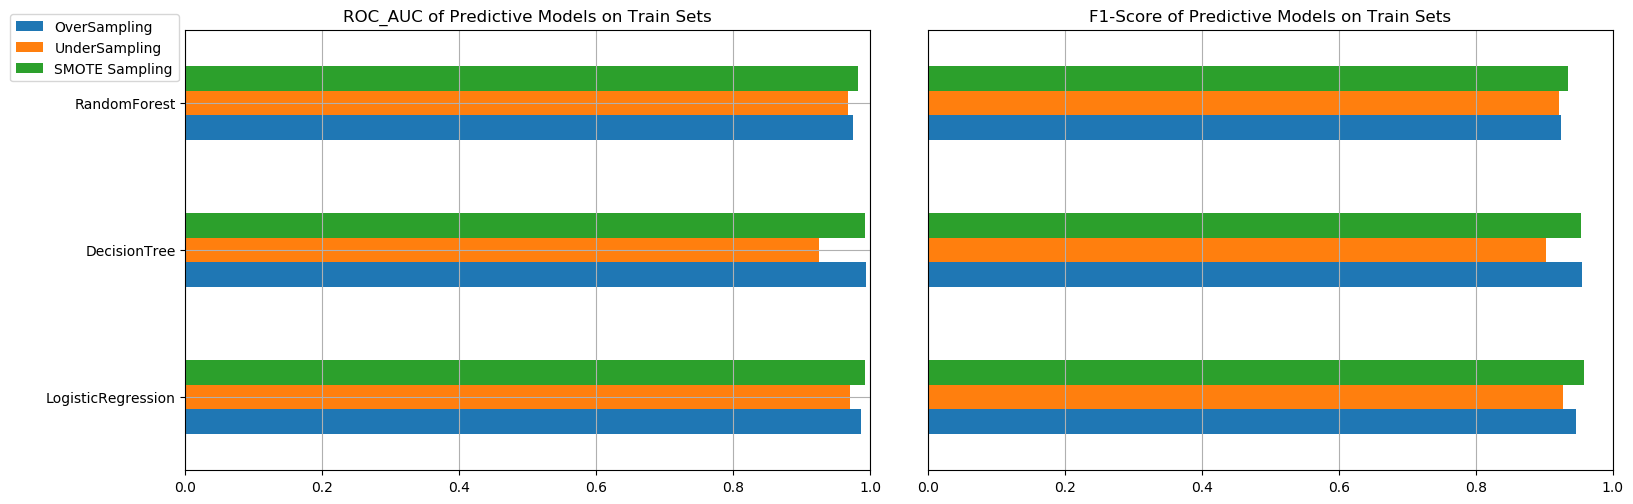

In [147]:
df_plot = pd.DataFrame(index=MT.keys(),columns=Names)

# Extracting data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.tight_layout()
for name in Names:
    for key, value in MT.items():
        x0=value['Table'][['Parameters', name]]
        x0=x0[x0[name, 'AUC Rank']==1]
        df_plot.loc[key, name]=x0.iloc[0][name, 'AUC']
df_plot.plot(kind='barh', grid=True, xlim=[0,1],
                   title='ROC_AUC of Predictive Models on Train Sets',ax=axes[0]).legend(bbox_to_anchor=(0, 1.05))

# Extracting data
for name in Names:
    for key, value in MT.items():
        x0=value['Table'][['Parameters', name]]
        x0=x0[x0[name, 'AUC Rank']==1]
        df_plot.loc[key, name]=x0.iloc[0][name, 'F1-Score']
Plot = df_plot.plot(kind='barh', grid=True, legend=False,xlim=[0,1],
                   title='F1-Score of Predictive Models on Train Sets',ax=axes[1]).get_yaxis().set_visible(False)

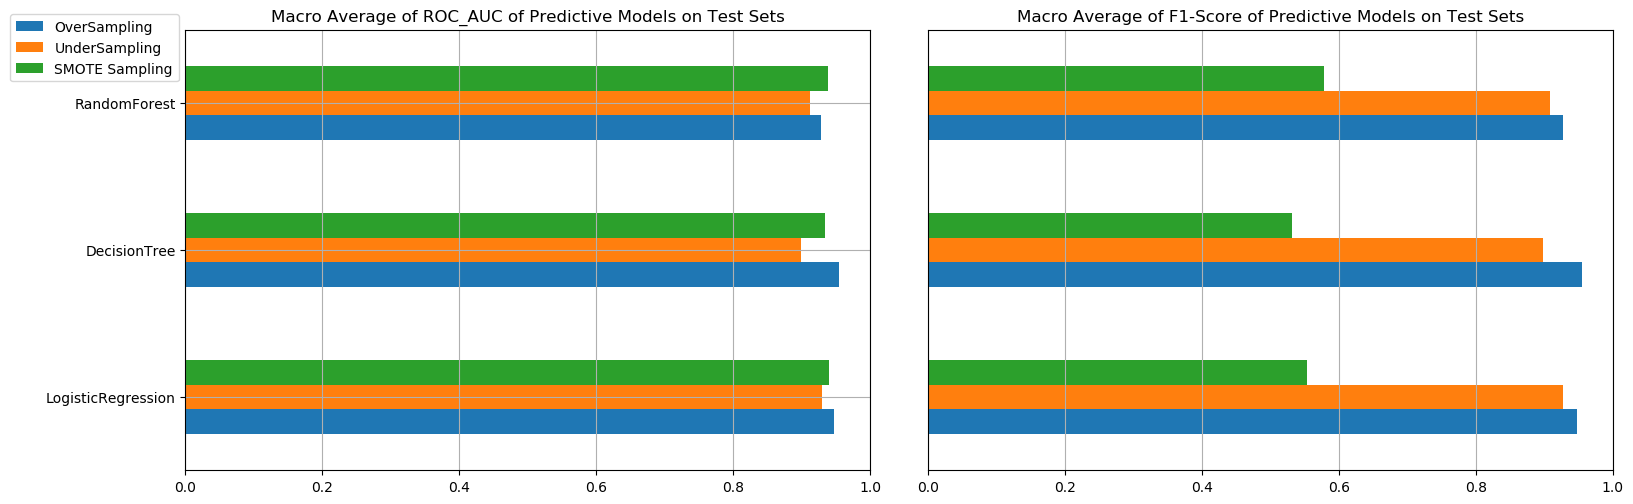

In [176]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

df_plot = pd.DataFrame(index=MT.keys(),columns=Names)

# Extracting data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.tight_layout()
for name in Names:
    for key, value in MT.items():
        y_pred=value['Model'][name].best_estimator_.predict(DataSets[name][2])
        df_plot.loc[key, name]= roc_auc_score(DataSets[name][3], y_pred)
df_plot.plot(kind='barh', grid=True, xlim=[0,1],
                   title='Macro Average of ROC_AUC of Predictive Models on Test Sets',ax=axes[0]).legend(bbox_to_anchor=(0, 1.05))

# Extracting data
for name in Names:
    for key, value in MT.items():
        y_pred=value['Model'][name].best_estimator_.predict(DataSets[name][2])
        df_plot.loc[key, name]= f1_score(DataSets[name][3], y_pred, average='macro')
Plot = df_plot.plot(kind='barh', grid=True, legend=False,xlim=[0,1],
                   title='Macro Average of F1-Score of Predictive Models on Test Sets',ax=axes[1]).get_yaxis().set_visible(False)

On the Train and Test sets all 4 models have similar performance. Now we need to analyze their performance on validation set.

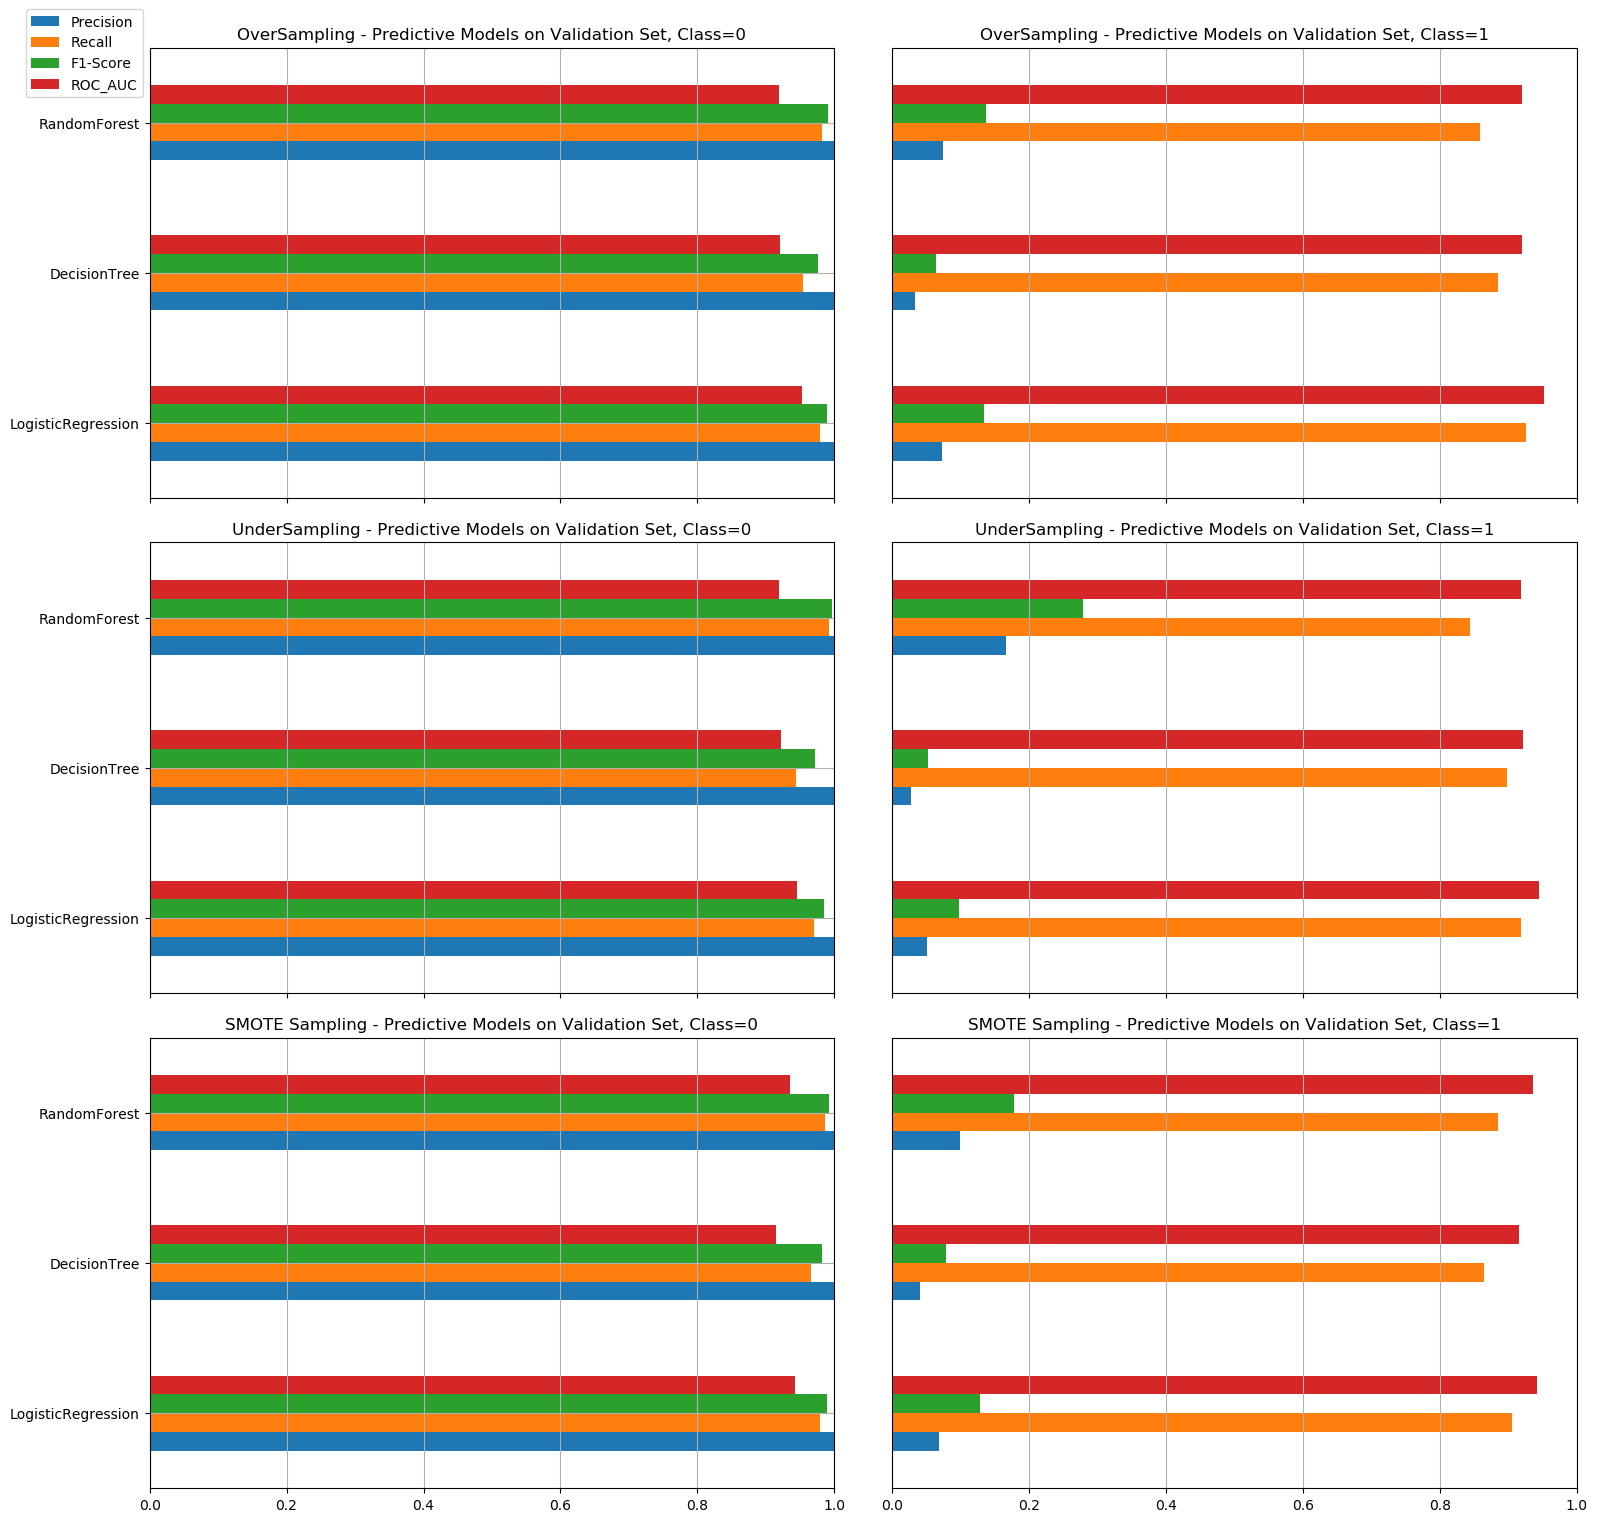

In [212]:
Mets={'Precision':precision_score, 'Recall':recall_score,
      'F1-Score':f1_score, 'ROC_AUC':roc_auc_score}

fig, axes = plt.subplots(nrows=len(Names), ncols=2,figsize=(15,15))
fig.tight_layout()

# Extracting data
count=0
for (count,name) in enumerate(Names):
    df_plot0 = pd.DataFrame(index=MT.keys(),columns=Mets.keys())
    df_plot1 = pd.DataFrame(index=MT.keys(),columns=Mets.keys())
    for key, value in MT.items():
        y_pred=value['Model'][name].best_estimator_.predict(X_validation)
        for met_key, met_value in Mets.items():
            mv=met_value(y_validation, y_pred, average=None)
            try:
                df_plot0.loc[key, met_key]= mv[0]
                df_plot1.loc[key, met_key]= mv[1]
            except:
                df_plot0.loc[key, met_key]= mv
                df_plot1.loc[key, met_key]= mv
    Legend= True if count==0 else False
    Plot0 = df_plot0.plot(kind='barh', grid=True, xlim=[0,1],ax=axes[count,0],legend=Legend,
                       title=name+' - Predictive Models on Validation Set, Class=0')
    if Legend==True: Plot0.legend(bbox_to_anchor=(0, 1.1)) 
    Plot1 = df_plot1.plot(kind='barh', grid=True, xlim=[0,1],ax=axes[count,1], legend=False,
                       title=name+' - Predictive Models on Validation Set, Class=1')
    Plot1.get_yaxis().set_visible(False)
    if count!=len(Names)-1:
        Plot0.tick_params(labelbottom=False)
        Plot1.tick_params(labelbottom=False) 

For validation set, metrics are divided on the two classes, so performance can better visualized. A sudden drop in F1-Score of all models is observed. The resean for this drop is the high level of histogram intersection in the data set. Models related to linear regression had the highest drop. To analyze this matter, the normalized histogram of all features for class 0 and 1 are plotted. 

In [278]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

def hist_intersection(df, target, bins):
    Classes = df[target].unique()
    HI=pd.DataFrame(columns=df.drop(columns=target).columns,index=[0])
    for name in df.drop(columns=target).columns:
        series1=df[df[target]==Classes[0]][name]
        series2=df[df[target]==Classes[1]][name]
        hist_1, _ = np.histogram(series1, density=True, bins=bins)
        hist_2, _ = np.histogram(series2, density=True, bins=bins)
        HI.loc[0,name]=return_intersection(hist_1, hist_2)
    return HI

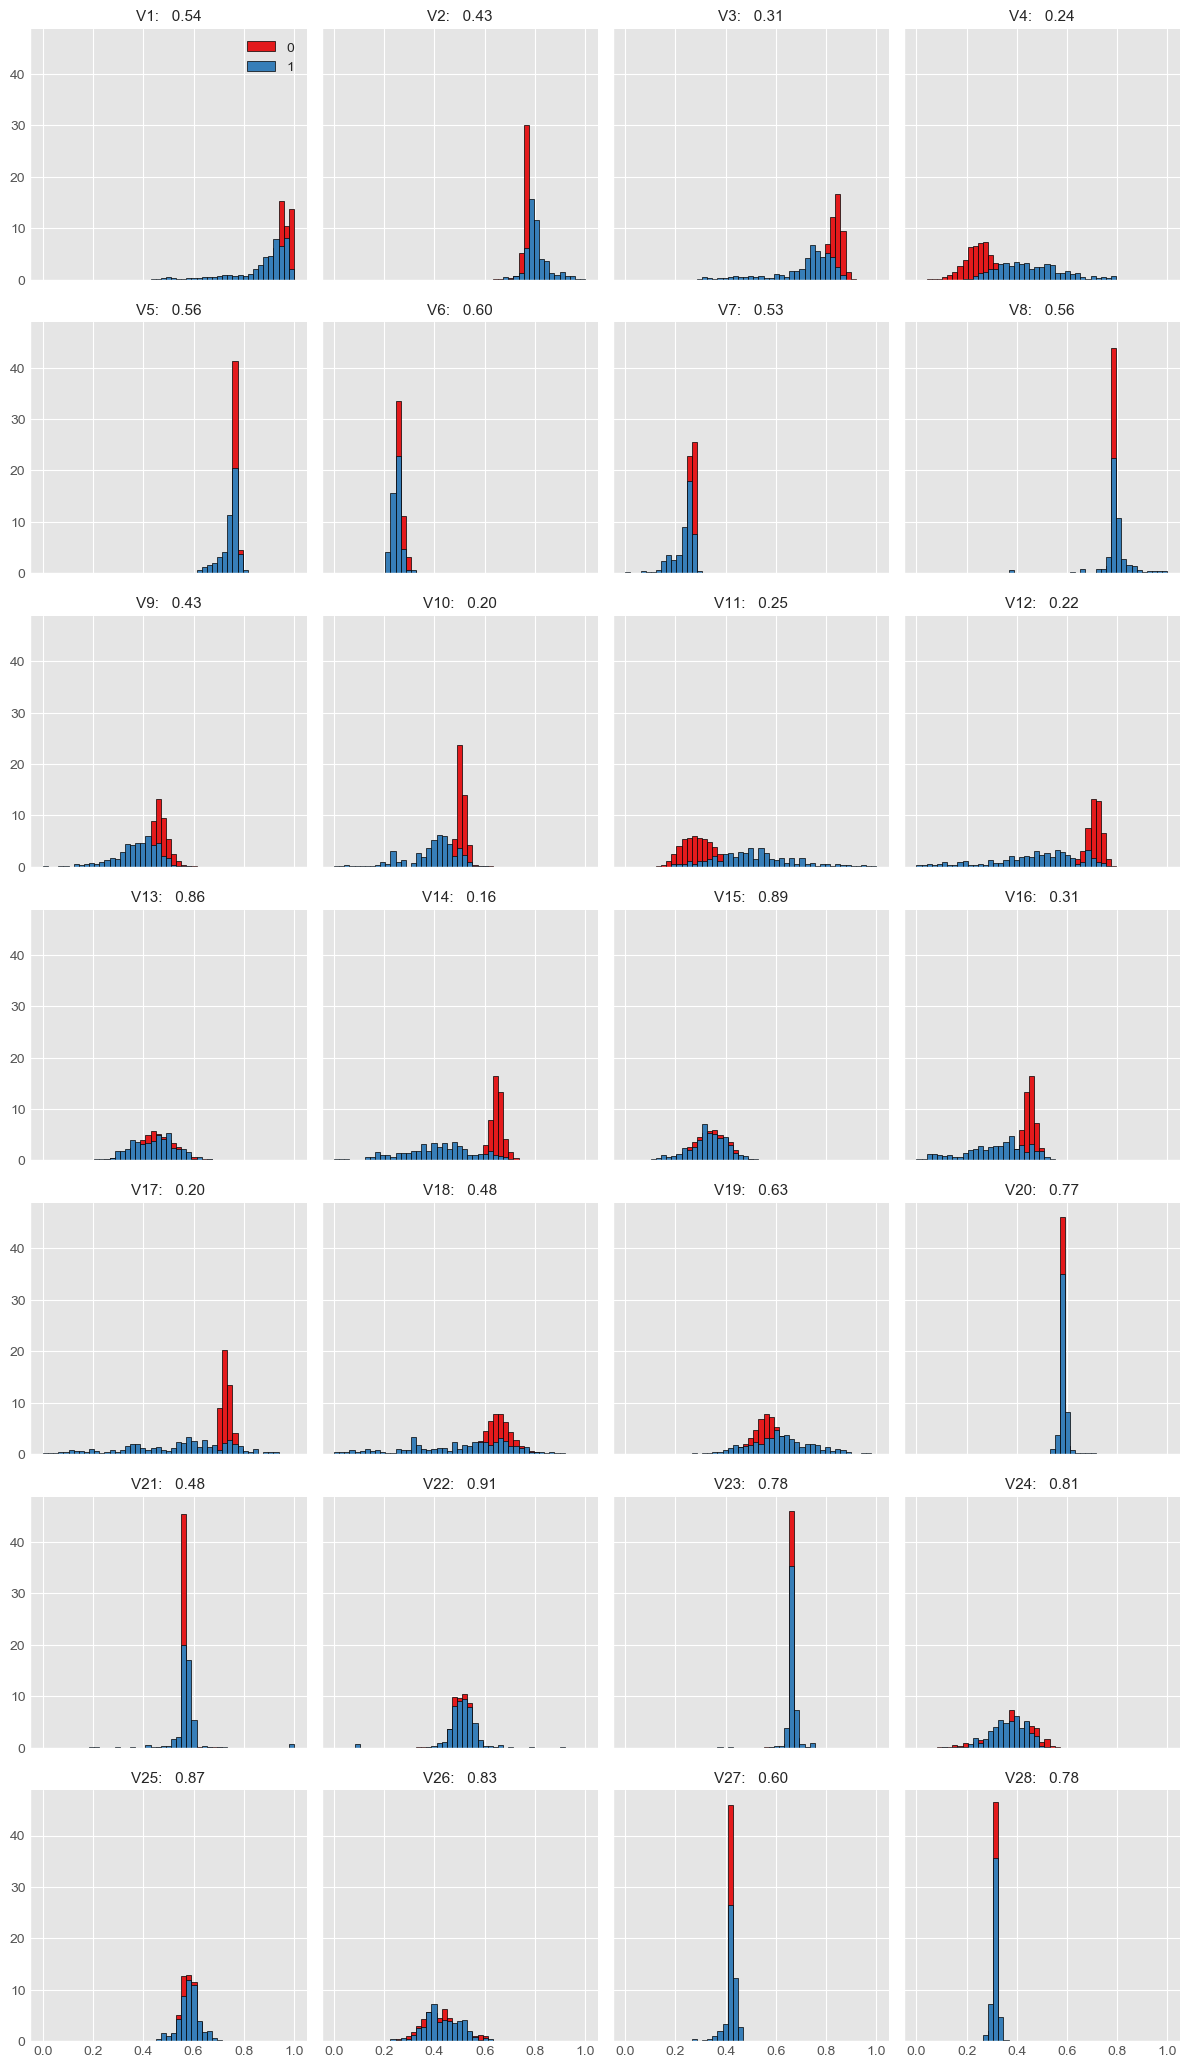

In [302]:
# from functions import hist_intersection

style.use('ggplot')
df_temp=df.drop(columns=['Class','Amount'])
normalized_df=(df_temp-df_temp.min())/(df_temp.max()-df_temp.min())
normalized_df= pd.concat([normalized_df, df['Class']], axis=1)

df5 = pd.melt(normalized_df, id_vars='Class', value_vars=normalized_df.drop(columns=['Class']).columns, value_name='value')

bins=np.linspace(df5.value.min(), df5.value.max(), 50)
g = sns.FacetGrid(df5, col="variable", hue="Class", palette="Set1", col_wrap=4)
g.map(plt.hist, 'value', bins=bins, ec="k", density=True,stacked=True, range=[df5.value.min(), df5.value.max()])

HI=hist_intersection(normalized_df, 'Class', bins)
g.axes[0].legend()

Col = normalized_df.drop(columns=['Class']).columns
for i in range(len(g.axes)):
#     g.axes[i].legend()
    g.axes[i].xaxis.label.set_visible(False)
    g.axes[i].set_title(Col[i] + ':   ' + "%.2f" %HI.loc[0,Col[i]], fontdict={'fontsize': 11})


As depicted, most features have histogram intersection values above 40, so it shouldn't come as a surpise to observe that models such as linear regression and SVC, due to their nature of classifying features which are closely knitted, have low performance on validation set.
On other hand, Decision Tree and Random Forset, even though they showed lower performance on training set, had better achievement. And out of these two, Random Forest had the best F1-Score, so this model is selected for further parameter tuning.

# Parameter Tuning of Random Forest

In [213]:
# for key, value in MT.items():
#     print(key)
#     Models=value['Model']
#     for Name in Names:
#         Estimator=Models[Name]
#         print(Name)
#         print(classification_report(y_validation, Estimator.best_estimator_.predict(X_validation)))
#         print(confusion_matrix(y_validation, Estimator.best_estimator_.predict(X_validation)))
#         print('\n')

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3)
# fig.tight_layout()
# style.use('ggplot')

# for count, name in enumerate(Names):
#     pt = PT1[name]
#     pt['C']=PT1['Parameters']['C']
#     pt['Penalty']=PT1['Parameters']['Penalty']
    
#     pt[pt["Penalty"]=="l1"].plot(x="C", y=["AUC", "F1-Score"], secondary_y="F1-Score", kind="line", 
#                                  logx=True, figsize=(18,5), title=name, ax=axes[count])